In [4]:
#### Necessary libraries ####

import numpy as np              # Numpy is the fundamental package for scientific computing in Python.
import netCDF4 as nc            # NetCDF is the data format of the meteorological data that we use.
import xarray as xr
import matplotlib.pyplot as plt # Matplotlib is a scientific plotting package.
import datetime                 # Datetime is a package to deal with dates.
import cartopy.crs as crs
import cartopy
from cmocean import cm
import os
import regionmask
import pandas as pd
from Functions import * 
import matplotlib as mpl
import pylab
from combine_data import read_data

# The statement below enforces the plots to be put into this notebook, instead of in their own windows.
%matplotlib inline

In [5]:
#----------------------------------------
# Figure settings
#----------------------------------------
small=18
font = {
        'weight' : 'normal',
        'size'   : small}
pylab.rc('font', **font)
pylab.rcParams['figure.figsize'] = (15.0, 10.0)
pylab.rcParams['xtick.major.pad']='10'
pylab.rcParams['ytick.major.pad']='15'
ms=10


# Data loading

In [6]:
path_to_data="./"
ds_pakistan = read_data(path_to_data, 'Pakistan')

Loading 2ldrm data for Pakistan
Loading UIB data for Pakistan
Loading UniVie data for Pakistan
Loading CHc data for Pakistan
Loading xu data for Pakistan
Loading tatfancheng data for Pakistan
Loading tracmass data for Pakistan
Loading ughent data for Pakistan
Loading utrack data for Pakistan
Loading wam2layers data for Pakistan
Skipping data for btrims, Pakistan - Unavailable
Loading uvigo data for Pakistan


In [7]:
directory_str = path_to_data

########################################################
## WRF-WVT                                            ##
########################################################

# Just csv file because of nature of simulations #
csv_wrf_wvt = pd.read_csv(directory_str+'results WRF-WVT/PakistanCase_Final.csv', sep=';', decimal=',',index_col=0)


In [8]:
'''Define regions, also provides an example how to define them using the regionmask package. 

In the plots below, 'rest of the world' is not included (it is in the netcdf file). Furthermore it would be nice/logical 
to include the event region, for the Pakistan case this is now part of the SAS region. 
'''

#### Sources per region, import necessary libraries ####
my_projection = crs.PlateCarree(central_longitude=0)

source_regions = xr.open_dataset("IPCCregions_Pakistancase.nc")

ar6_all = regionmask.defined_regions.ar6.all
selected_regions = ar6_all[['NEAF', 'SEAF', 'WCA', 'TIB', 'ARP', 'SAS', 'ARS', 'BOB', 'EIO',
       'SIO']]

In [9]:
a_gridcell_new_pakistan, l_ew_gridcell_pakistan, l_mid_gridcell_pakistan = get_grid_info_new(np.arange(24,30.1,0.25), np.arange(67,71.1,0.25))#(71-67)/0.25 * (30-24)/

In [10]:
sum(a_gridcell_new_pakistan)*24

array([4.12920794e+11])

In [29]:
list_reordered = ['2ldrm',
 'flexpart_uib',
 'flexpart_univie',
 'lagranto_CHc',
 'flexpart_xu',
 'flexpart_tatfancheng',
 'Vigo_e2_Sodemann',
 'TRACMASS',
 'ghent_e1',
 'ghent_e2',
 'ghent_e3',
 'ghent_e4',
 'ghent_e5',
 'utrack_e1',
 'utrack_e2',
 'utrack_e3',
 'utrack_e4',
 'utrack_e5',
 'wam2layers',
 'Vigo_e1_Stohl']

all_maps = {kk:ds_pakistan[kk] for kk in list_reordered}

all_maps = xr.Dataset(all_maps)

In [31]:
all_maps_frac={}
all_maps_abs={}
all_maps_frac_regional={}
all_maps_regional={}

a_gridcell_new, l_ew_gridcell, l_mid_gridcell = get_grid_info_new(all_maps.lat.values, all_maps.lon.values) #Calcluate grid cell area
a_gridcell_newp, l_ew_gridcellp, l_mid_gridcellp = get_grid_info_new(np.arange(24,30.1,0.25), np.arange(67,71.1,0.25))#(71-67)/0.25 * (30-24)/
for kk in list(all_maps.keys()):
    all_maps_frac[kk] = calc_fractional_sources(all_maps[kk])
    all_maps_frac_regional[kk] = calc_regional_sources(all_maps_frac[kk],selected_regions)[0]
    all_maps_abs[kk] = ( all_maps[kk] * a_gridcell_new ) / (sum(a_gridcell_newp)*24)
    all_maps_regional[kk] = calc_regional_sources(all_maps_abs[kk],selected_regions)[0]



/usr/local/Miniconda3-envs/envs/2023/envs/iacpy3_2023/lib/python3.11/site-packages/regionmask/core/mask.py:166: FutureWarning: Passing 'lon_name' and 'lat_name' is deprecated. Please pass the lon and lat coordinates direcly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(
/usr/local/Miniconda3-envs/envs/2023/envs/iacpy3_2023/lib/python3.11/site-packages/regionmask/core/mask.py:166: FutureWarning: Passing 'lon_name' and 'lat_name' is deprecated. Please pass the lon and lat coordinates direcly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(
/usr/local/Miniconda3-envs/envs/2023/envs/iacpy3_2023/lib/python3.11/site-packages/regionmask/core/mask.py:166: FutureWarning: Passing 'lon_name' and 'lat_name' is deprecated. Please pass the lon and lat coordinates direcly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(
/usr/local/Miniconda3-envs/envs/2023/envs/iacpy3_2023/lib/python3.11/site-packages/regionmask/core/mask.py:166: FutureWarning: Passing 'lon_name'

In [32]:
srcs_wrf_wvt=all_maps_regional[kk].copy()
srcs_wrf_wvt.values=csv_wrf_wvt.loc['2022-08-10_2022-08-24'][1:-2].values

srcs_regional_combined = xr.concat([all_maps_regional[kk].expand_dims(ensemble=1) for kk in list(all_maps.keys())[:-1]
                    ],dim='ensemble')
srcs_regional_combined = xr.concat([srcs_regional_combined,
                  srcs_wrf_wvt.expand_dims(ensemble=1)
                    ],dim='ensemble')
srcs_regional_combined = xr.concat([srcs_regional_combined,
                  all_maps_regional['Vigo_e1_Stohl'].expand_dims(ensemble=1)
                    ],dim='ensemble')

In [57]:
n_lines = 11
cmap = mpl.colormaps['RdYlBu_r']

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines))

In [48]:
precip_sums = np.array([np.sum(all_maps_abs[k]) for k in list(all_maps_abs.keys())])
precip_sums = np.concatenate([precip_sums[:-1],[csv_wrf_wvt.loc['2022-08-10_2022-08-24'][0]],[precip_sums[-1]]])

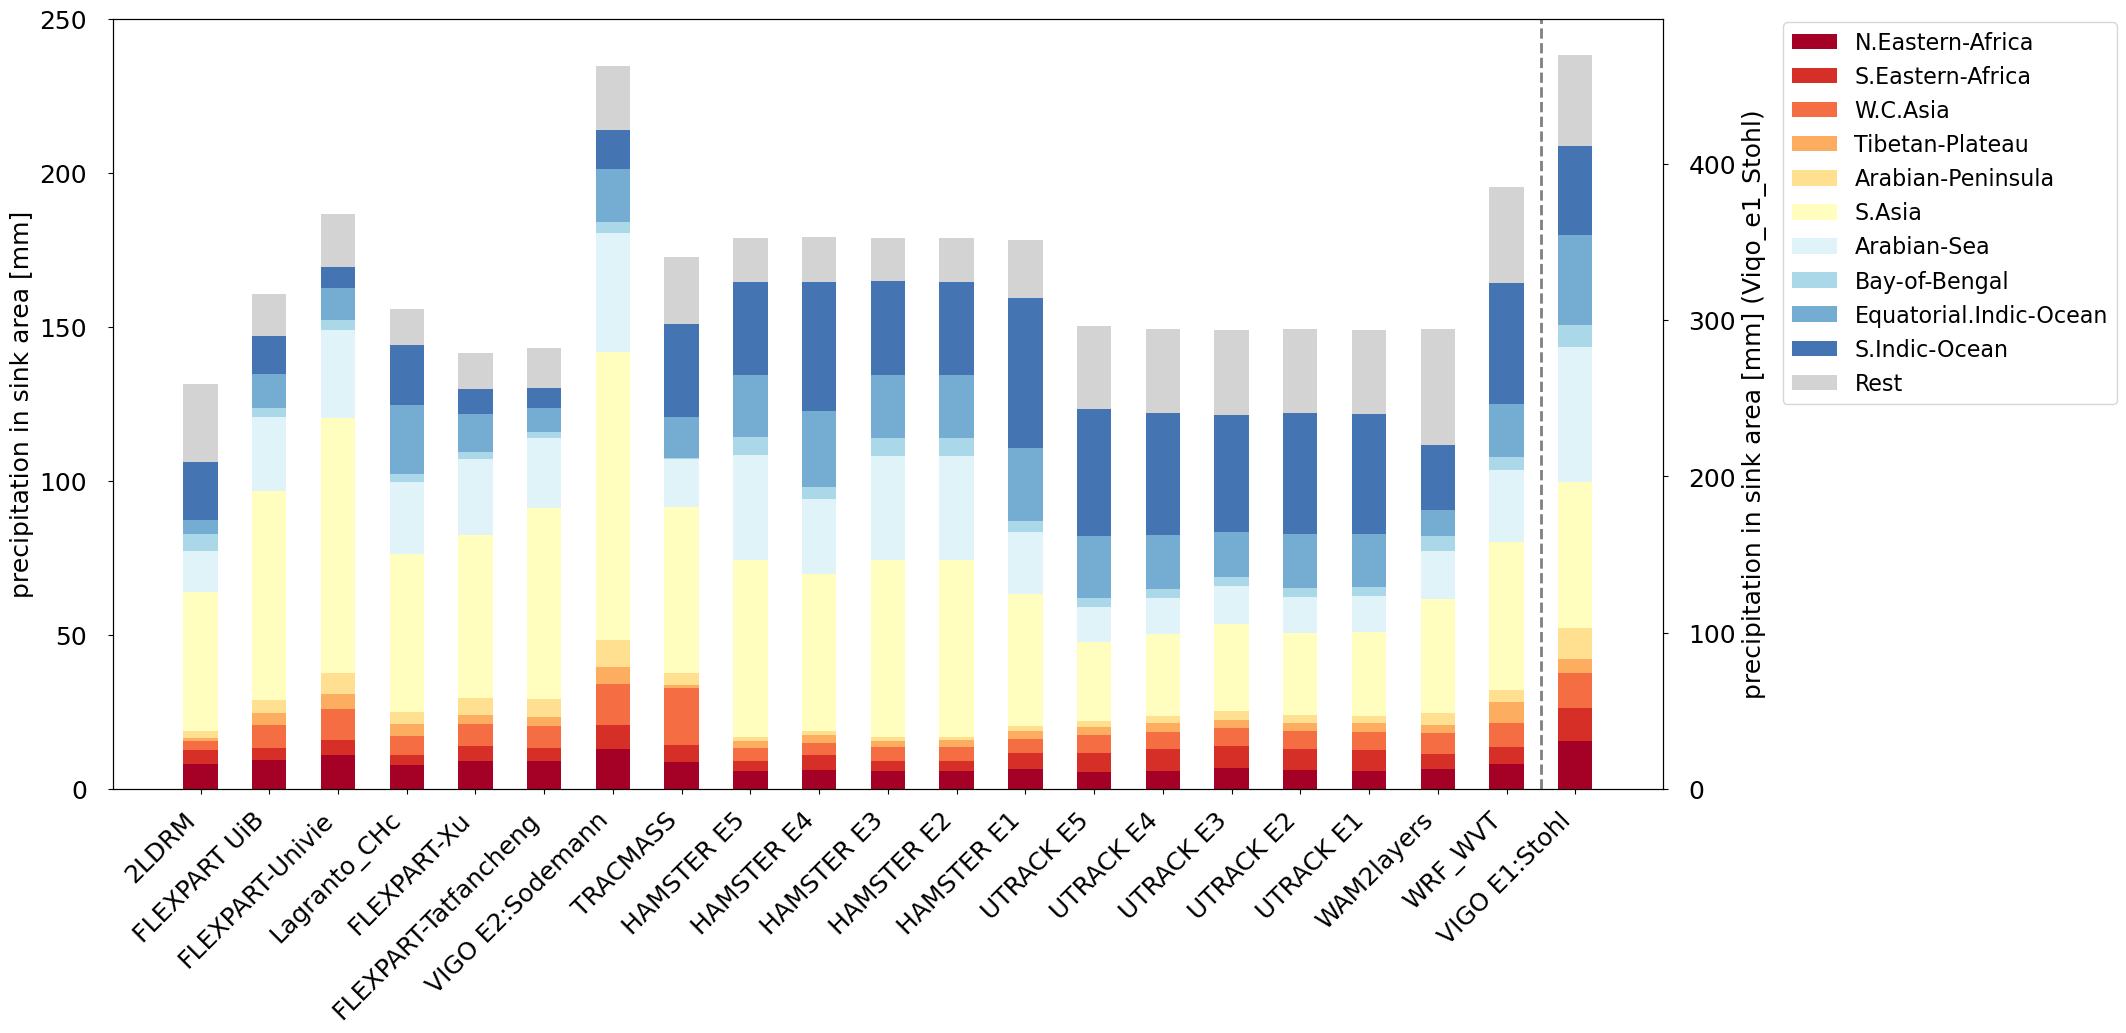

In [60]:
modelnames=["2LDRM","FLEXPART UiB", "FLEXPART-Univie",'Lagranto_CHc',"FLEXPART-Xu","FLEXPART-Tatfancheng", "VIGO E2:Sodemann",
            "TRACMASS", "HAMSTER E5", "HAMSTER E4", "HAMSTER E3", "HAMSTER E2", "HAMSTER E1",
             "UTRACK E5", "UTRACK E4", "UTRACK E3", "UTRACK E2", "UTRACK E1", 
             "WAM2layers", "WRF_WVT","VIGO E1:Stohl"]

fig, ax = plt.subplots(figsize=(20,10))
ax2 = ax.twinx()
bottom = np.zeros(len(modelnames)-2)
bottom2 = np.zeros(1)
bottom3 = np.zeros(1)
for ii in range(11):# srcs_Vigo_e1_Stohl_regional:
    if ii!=10:
        p = ax.bar(range(len(modelnames)-2), srcs_regional_combined[:-2,ii].values, 0.5, color=colors[10-ii], label=srcs_regional_combined.names.values[ii], bottom=bottom)
        bottom += srcs_regional_combined[:-2,ii].values
        p = ax2.bar(len(modelnames)-1, srcs_regional_combined[-1,ii].values, 0.5, color=colors[10-ii], bottom=bottom2)
        bottom2 += srcs_regional_combined[-1,ii].values
        p = ax.bar(len(modelnames)-2, srcs_regional_combined[-2,ii].values, 0.5, color=colors[10-ii], bottom=bottom3)
        bottom3 += srcs_regional_combined[-2,ii].values    

    else:
        p = ax.bar(range(len(modelnames)-2), precip_sums[:-2]-bottom, 0.5, label='Rest', bottom=bottom, color='lightgrey')
        p = ax2.bar(len(modelnames)-1, precip_sums[-1]-bottom2, 0.5,  bottom=bottom2, color='lightgrey')
        p = ax.bar(len(modelnames)-2, precip_sums[-2]-bottom3, 0.5, bottom=bottom3, color='lightgrey')

ax.axvline(x=len(modelnames)-1.5,color='grey',linestyle='--',linewidth=2.0)

ax.set_xticks(range(len(modelnames)))
ax.set_xticklabels(modelnames, rotation=45, ha='right')
ax.set_ylabel('precipitation in sink area [mm]')
ax2.set_ylabel('precipitation in sink area [mm] (Viqo_e1_Stohl)')
ax.set_ylim(0,250)
ax.legend(bbox_to_anchor=(1.3, 1.01),fontsize=16)
#plt.savefig("bar_plots_absolute.png", bbox_inches = "tight")


In [50]:
srcs_wrf_wvt=all_maps_frac_regional[kk].copy()
srcs_wrf_wvt.values=csv_wrf_wvt.loc['fractions'][1:-2].values

srcs_regional_frac_combined = xr.concat([all_maps_frac_regional[kk].expand_dims(ensemble=1) for kk in list(all_maps.keys())[:-1]
                    ],dim='ensemble')
srcs_regional_frac_combined = xr.concat([srcs_regional_frac_combined,
                  srcs_wrf_wvt.expand_dims(ensemble=1)
                    ],dim='ensemble')
srcs_regional_frac_combined = xr.concat([srcs_regional_frac_combined,
                  all_maps_frac_regional['Vigo_e1_Stohl'].expand_dims(ensemble=1)
                    ],dim='ensemble')

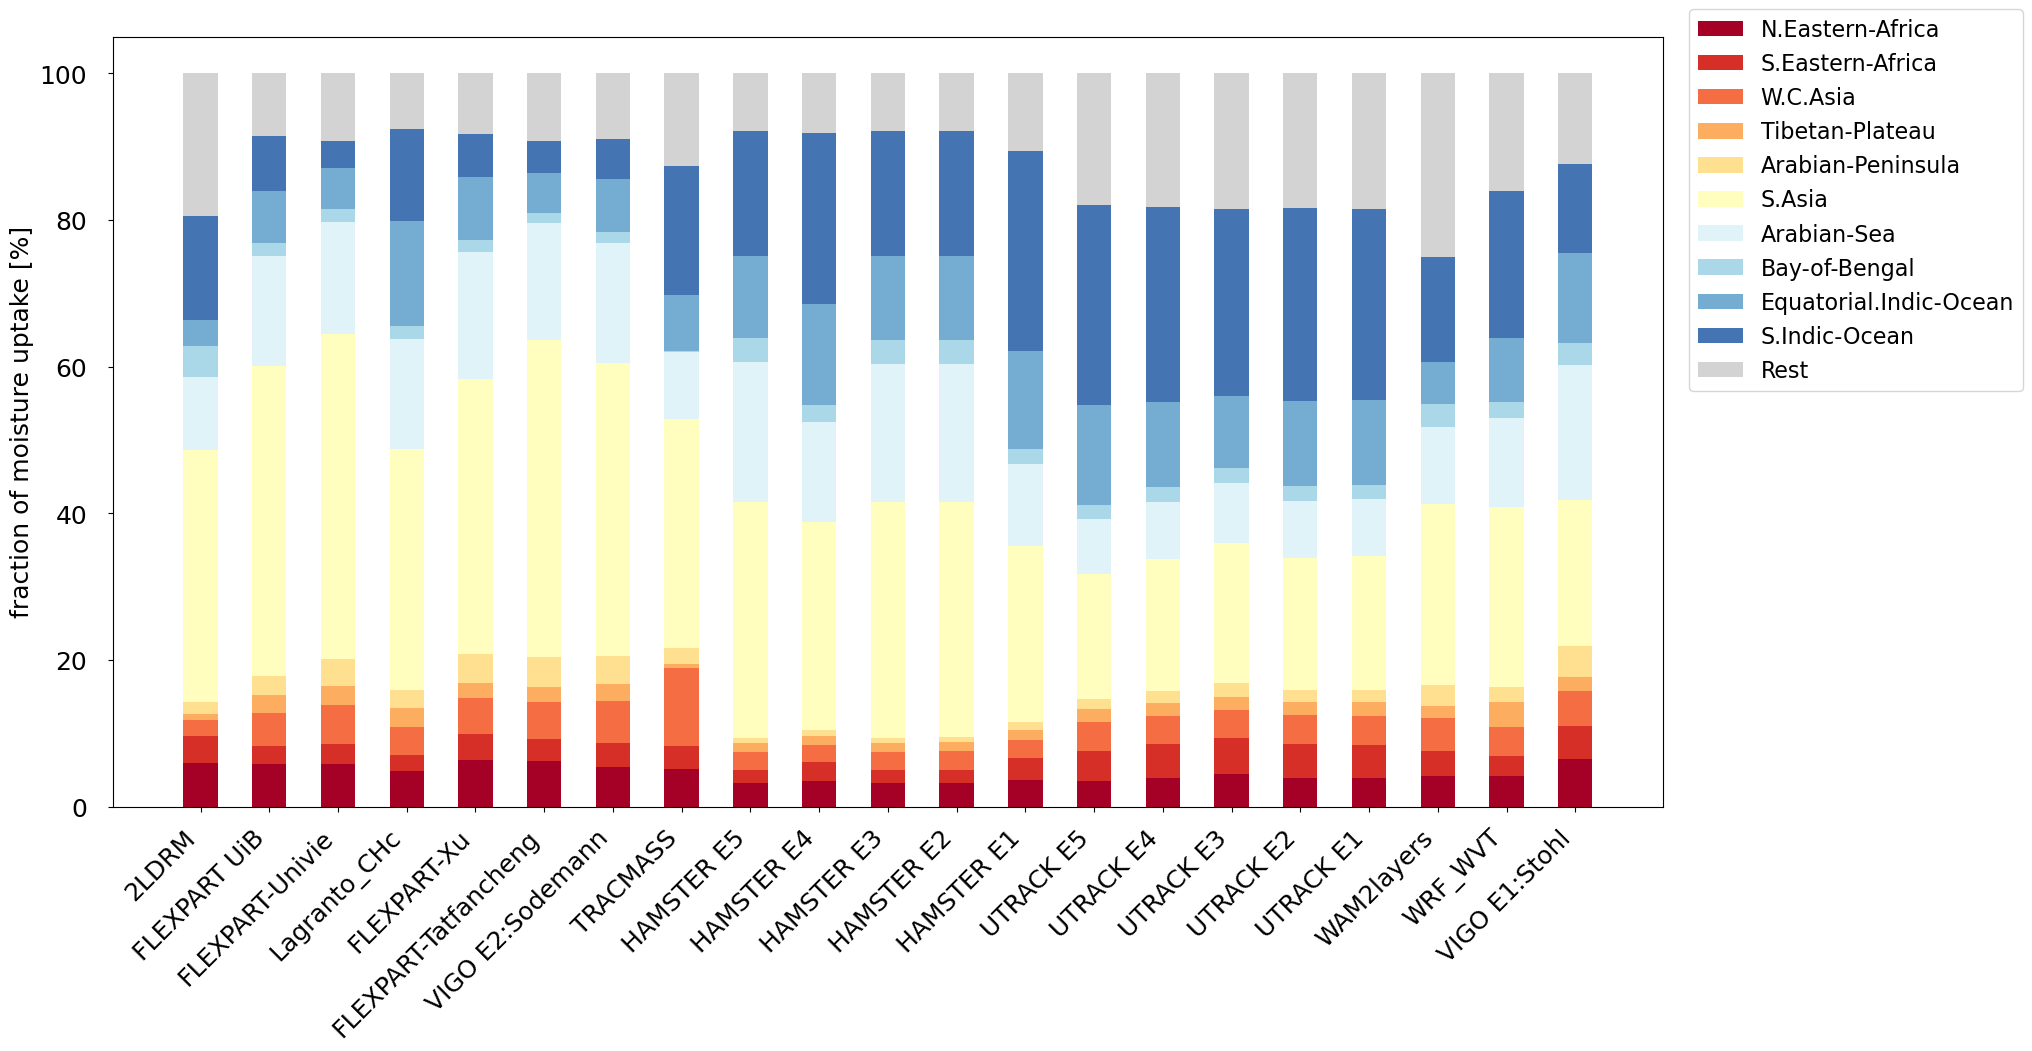

In [62]:
modelnames=["2LDRM","FLEXPART UiB", "FLEXPART-Univie",'Lagranto_CHc',"FLEXPART-Xu","FLEXPART-Tatfancheng", "VIGO E2:Sodemann",
            "TRACMASS", "HAMSTER E5", "HAMSTER E4", "HAMSTER E3", "HAMSTER E2", "HAMSTER E1",
             "UTRACK E5", "UTRACK E4", "UTRACK E3", "UTRACK E2", "UTRACK E1", 
             "WAM2layers", "WRF_WVT","VIGO E1:Stohl"]

fig, ax = plt.subplots(figsize=(20,10))
bottom = np.zeros(len(modelnames))
for ii in range(11):# srcs_Vigo_e1_Stohl_regional:
    if ii!=10:
        p = ax.bar(modelnames, srcs_regional_frac_combined[:,ii].values, 0.5, color=colors[10-ii], label=srcs_regional_frac_combined.names.values[ii], bottom=bottom)
        bottom += srcs_regional_frac_combined[:,ii].values
    else:
        p = ax.bar(modelnames, np.array([100 for i in range(len(modelnames))])-bottom, 0.5, label='Rest', bottom=bottom, color='lightgrey')
        #bottom += [100 for i in range(18)]
plt.xticks(rotation=45, ha='right')

ax.set_ylabel('fraction of moisture uptake [%]')

ax.legend(bbox_to_anchor=(1.01, 1.05),fontsize=16)
#plt.savefig("bar_plots_relative.png", bbox_inches = "tight")
